# Import

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from utils import *
import numpy as np
import plotly.graph_objs as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import Image, display
import pandas as pd
from scipy import stats
from scipy.stats import f_oneway
from scipy.optimize import linear_sum_assignment
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 1. CMU DATASET ANALYSIS

In [2]:
DATA_FOLDER = './datasets/'

In [3]:
# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB',
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name',
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER + 'CMU_dataset/character.metadata.tsv', names=columns_char,
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

# Loading movies
columns_mov = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Movie_name', 'Movie_release_date',
               'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
               'Movie_genres']

cmu_df = pd.read_table(DATA_FOLDER + 'CMU_dataset/movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

The goal of our study is to analyze what factors contribute to the success of a movie. Let us first have a quick analysis on our provided data set.


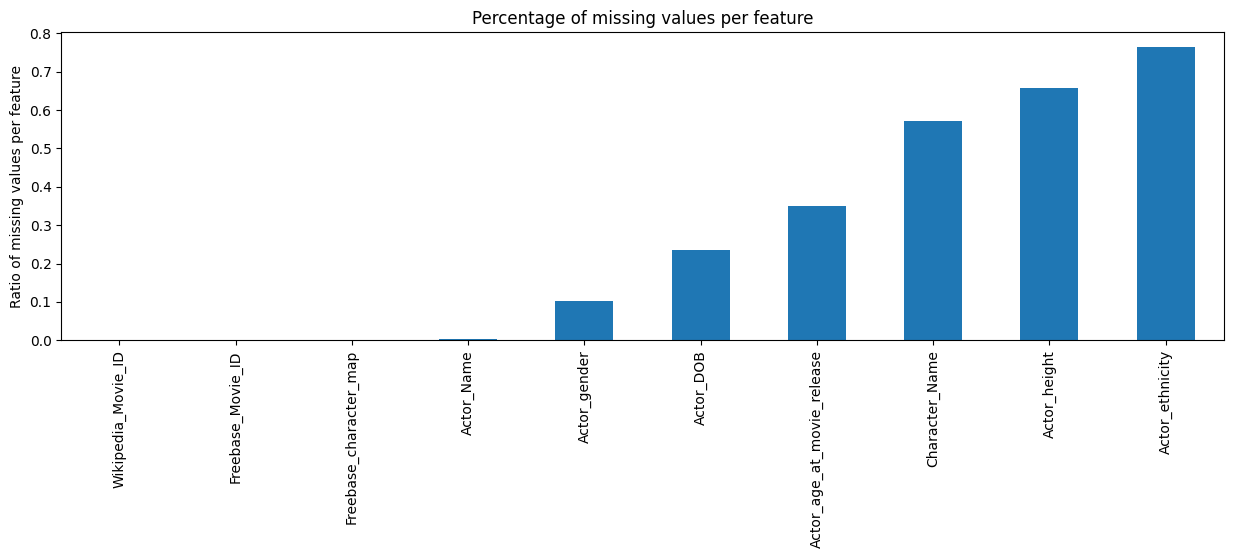

In [4]:
plot_missing_values_percentage(characters)

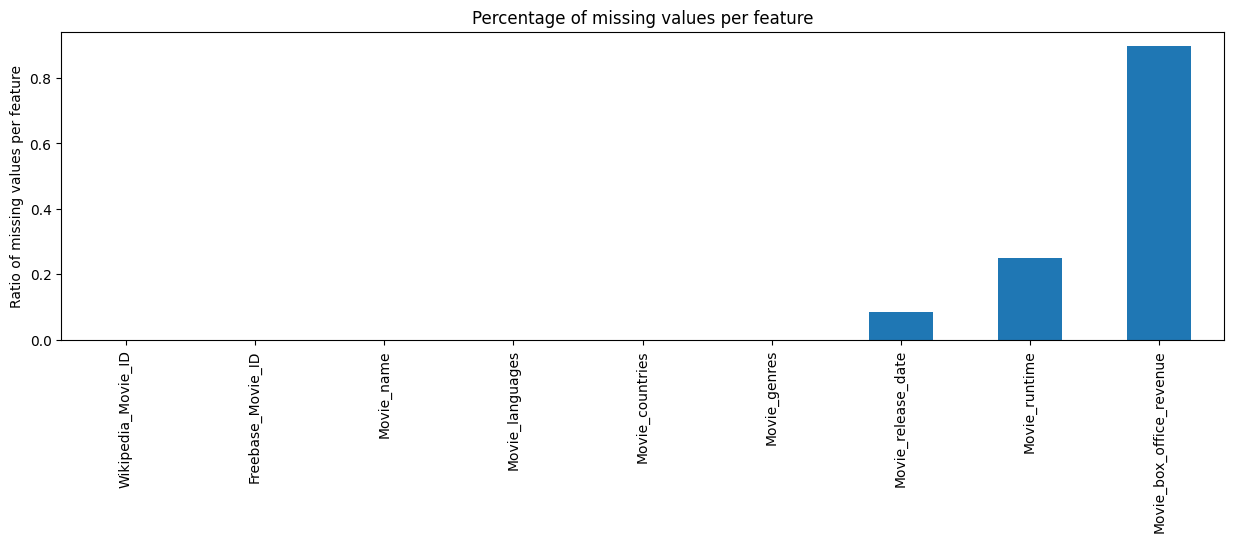

In [5]:
plot_missing_values_percentage(cmu_df)

**Comment:** Good factors to measure the success of a movie are its ratings and its revenues. We can see that our data set does not contain any information on movie ratings, and has a very high percentage of missing values for the movie revenues.
**Solution:** Merge the CMU dataset with our additional dataset that contains ratings informations and additional box office revenues

### Creating a mapping between the IMDB Id and the Freebase_Movie_ID

In [6]:
data = query_wikidata()

In [7]:
imbd_freebase = json_to_df(data)

In [8]:
imbd_freebase.drop_duplicates(subset=['imdb_id', 'freebase_id'], inplace=True)

# 2. TMBD Analysis

In [9]:
pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')

/var/folders/65/f0hg7h7d5jv5q1_r6jzt43bh0000gn/T/ipykernel_20508/4053239051.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')


### Drop Non-related Columns

In [10]:
pd_tmbd = pd_tmbd.drop(
    ['adult', 'belongs_to_collection', 'homepage', 'original_title', 'overview', 'poster_path', 'status', 'tagline',
     'video'], axis=1)

#### Evaluate the literal value to convert it to array

In [11]:
# Apply the function to the corresponding columns
column_names = ['genres', 'production_companies', 'production_countries', 'spoken_languages']
for column in column_names:
    pd_tmbd[column] = pd_tmbd[column].apply(lambda x: safe_literal_eval(x))
    pd_tmbd[column] = pd_tmbd[column].apply(lambda x: get_names(x))


# 3. Merging the CMU and the TMDB Datasets

In [12]:
cmu_df = pd.merge(left=cmu_df, right=imbd_freebase, right_on='freebase_id', left_on='Freebase_Movie_ID',
                  how='inner').drop(columns='freebase_id')

In [13]:
movies = pd.merge(right=cmu_df, left=pd_tmbd, on='imdb_id', how='inner').drop_duplicates(subset='imdb_id')

### Replace with NaN values

In [14]:
movies['popularity'] = movies['popularity'].astype(float)
movies['popularity'].replace(0.0, np.nan, inplace=True)

movies['budget'] = movies['budget'].astype(float)
movies['budget'].replace(0.0, np.nan, inplace=True)

movies['revenue'].replace(0.0, np.nan, inplace=True)
movies['Movie_box_office_revenue'].replace(0.0, np.nan, inplace=True)

In [15]:
movies['Movie_box_office_revenue'] = movies['Movie_box_office_revenue'].fillna(movies['revenue'])
movies.drop(columns='revenue', inplace=True)

### Preprocessing the genres, languages and countries columns

**Comment:** We have the columns mentioned above are represented as dictionaries with key freebase_id and values country names, genres and languages of the movie with id freebase_id, that's why we decided to retrieve the values and store them instead of having the dictionary representation

In [16]:
movies['Movie_genres'] = movies['Movie_genres'].apply(transform_row)
movies['Movie_countries'] = movies['Movie_countries'].apply(transform_row)
movies['Movie_languages'] = movies['Movie_languages'].apply(transform_row)

In [17]:
movies.drop(columns=['Wikipedia_Movie_ID', 'title', 'runtime', 'original_language', 'production_companies', 'id',
                     'Movie_genres'], axis=1, inplace=True)

### Preprocessing the release date column

**We have two release date columns 'release_date' of the TMDB dataset and 'Movie_release_date' of the CMU dataset. Let us compare between the two columns to decide which one to drop**

In [18]:
columns_to_check = ['Movie_release_date', 'release_date']

for column in columns_to_check:
    movies['date_format_' + column] = movies[column].apply(
        lambda date: determine_date_format(str(date)))
    print(f"Date formats in {column}:")
    print(movies['date_format_' + column].value_counts())
    print()

Date formats in Movie_release_date:
date_format_Movie_release_date
yyyy-mm-dd    16505
yyyy           9344
unknown        1581
Name: count, dtype: int64

Date formats in release_date:
date_format_release_date
yyyy-mm-dd    27423
unknown           7
Name: count, dtype: int64


After this comparison between the two release date columns, we decided to use the release date column from the tmdb dataset, because it represents the date of movies in the same format yyyy-mm-dd.Also, given the count of unknown release date format we conclude that there is 7 missing values in this column.
We transform the release date to 3 columns, namely year, month and day. To do so, we change the type of the release date column from string to Date-time representation. From that, we will extract the year, month and day of each movie’s release date.

In [19]:
# Drop the 7 unknown formats
movies = movies[movies['date_format_release_date'] != 'unknown']
# Drop the non-useful columns
movies.drop(columns=['date_format_Movie_release_date', 'date_format_release_date', 'Movie_release_date'],
                     axis=1, inplace=True)

In [20]:
# Convert 'release_date' to datetime
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')

# Extract year, month, and day of each movie into separate columns
movies['year'] = movies['release_date'].dt.year
movies['month'] = movies['release_date'].dt.month
movies['day_week'] = movies['release_date'].dt.day_name()

In [21]:
display(movies[['release_date', 'year', 'month', 'day_week']])

,release_date,year,month,day_week
0,1995-10-30,1995,10,Monday
1,1995-12-15,1995,12,Friday
2,1995-12-22,1995,12,Friday
3,1995-12-22,1995,12,Friday
4,1995-02-10,1995,2,Friday
...,...,...,...,...
27447,1972-01-01,1972,1,Saturday
27448,1946-03-29,1946,3,Friday
27449,1991-05-13,1991,5,Monday
27450,2003-08-01,2003,8,Friday


## Adjusting movies dataframe to account for inflation

Since we are considering movies on a large time window, we need to account for inflation. Otherwise, recent movies will have a clear advantage on older movies when accounting for variables like the budget or th box office revenue. To do so, we import a new dataset of US consumer price over the years. For each movie, we calculate the inflation factor from its release year to the present year 2020. Using CPI, the factor can be calculated as CPI in current year / CPI in release year. For simplicity, we are not going to consider the variations of the CPI within each year, we are only going to say that the CPI for a given year is the CPI on january.

In [22]:
# reading the inflation dataframe
inflation = pd.read_csv(DATA_FOLDER+'KAGGLE_dataset/US CPI.csv')

In [23]:
# Calculate Annual CPI by computing the mean
inflation['Yearmon'] = pd.to_datetime(inflation['Yearmon'], format='%d-%m-%Y')
inflation['Year'] = inflation['Yearmon'].dt.year
annual_cpi = inflation.groupby('Year')['CPI'].mean()
# Create a CPI mapping from year to annual CPI
cpi_mapping = annual_cpi.to_dict()
# Adding the corresponding CPI index the movies dataframe
movies['annual_cpi'] = movies['year'].map(cpi_mapping)

In [24]:
# Choose the most recent year in your dataset as the base year
base_year = movies['year'].max()
base_year_cpi = cpi_mapping[base_year]

In [25]:
# Apply the inflation adjustment
movies = movies.apply(adjust_for_inflation, axis=1, args=(base_year_cpi,))

In [26]:
movies.drop(columns=['annual_cpi'],
                     axis=1, inplace=True)

### Calculate the Net profit for every movie

In [27]:
movies['Net profit'] = movies['Movie_box_office_revenue'] - movies['budget']

In [28]:
# Reorder the columns of the movie dataset
movies = movies[
    ['Freebase_Movie_ID', 'imdb_id', 'Movie_name', 'release_date', 'year', 'month', 'day_week', 'genres', 'spoken_languages',
     'Movie_languages', 'Movie_countries', 'budget', 'Movie_box_office_revenue',
     'Net profit', 'popularity', 'Movie_runtime', 'vote_average', 'vote_count']]

display(movies)


,Freebase_Movie_ID,imdb_id,Movie_name,release_date,year,month,day_week,genres,spoken_languages,Movie_languages,Movie_countries,budget,Movie_box_office_revenue,Net profit,popularity,Movie_runtime,vote_average,vote_count
0,/m/0dyb1,tt0114709,Toy Story,1995-10-30,1995,10,Monday,"[Animation, Comedy, Family]",[English],[English Language],[United States of America],5.095265e+07,6.147586e+08,5.638059e+08,21.946943,77.0,7.7,5415.0
1,/m/09w353,tt0113497,Jumanji,1995-12-15,1995,12,Friday,"[Adventure, Fantasy, Family]","[English, Français]","[French Language, English Language]","[United States of America, Japan]",1.103974e+08,4.463406e+08,3.359431e+08,17.015539,104.0,6.9,2413.0
2,/m/0676dr,tt0113228,Grumpier Old Men,1995-12-22,1995,12,Friday,"[Romance, Comedy]",[English],"[Italian Language, English Language]",[United States of America],NaN,1.214686e+08,NaN,11.712900,101.0,6.5,92.0
3,/m/03vny7,tt0114885,Waiting to Exhale,1995-12-22,1995,12,Friday,"[Comedy, Drama, Romance]",[English],[English Language],[United States of America],2.717475e+07,1.383401e+08,1.111654e+08,3.859495,121.0,6.1,34.0
4,/m/094g2z,tt0113041,Father of the Bride Part II,1995-02-10,1995,2,Friday,[Comedy],[English],[English Language],[United States of America],NaN,1.300891e+08,NaN,8.387519,106.0,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27447,/m/0crtfny,tt0069215,St. Michael Had a Rooster,1972-01-01,1972,1,Saturday,[],[Italiano],[Italian Language],[Italy],NaN,NaN,NaN,0.225051,90.0,6.0,3.0
27448,/m/0bf79j,tt0038621,House of Horrors,1946-03-29,1946,3,Friday,"[Horror, Mystery, Thriller]",[English],[English Language],[United States of America],NaN,NaN,NaN,0.222814,65.0,6.3,8.0
27449,/m/0g0dy6,tt0102797,Robin Hood,1991-05-13,1991,5,Monday,"[Drama, Action, Romance]",[English],[English Language],[United Kingdom],NaN,NaN,NaN,5.683753,116.0,5.7,26.0
27450,/m/065ztgt,tt0303758,Betrayal,2003-08-01,2003,8,Friday,"[Action, Drama, Thriller]",[English],[English Language],[United States of America],NaN,NaN,NaN,0.903007,90.0,3.8,6.0


# Sub-Question 1: Relationship between the production countries and the movies success

One of our subquestions is to understand and analyse factors that influence the success of a movie. One of these such factors is the country of production (It's the country where the movie was released). We might think that a movie may be more or less successful depending on its production country. Let's take a look at the data to inspect this aspect.

In [156]:
movie_copy = movies.copy()

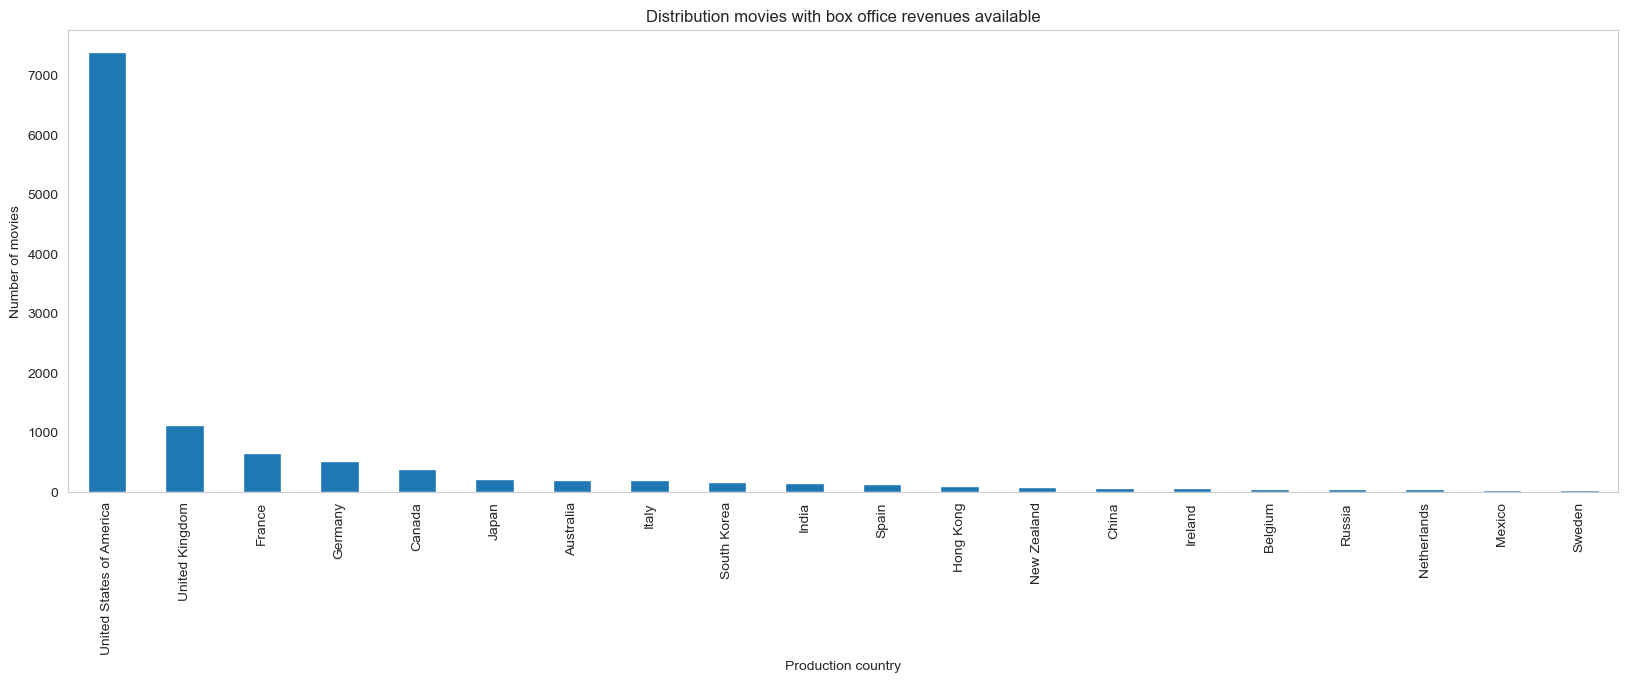

In [157]:
# Plot distribution of movies with a box office revenue
movies_with_revenues = movie_copy.dropna(subset=['Movie_box_office_revenue'])

plot_top_20_most_popular(movies_with_revenues, 'Movie_countries', 'Production country', 'Number of movies',
                         'Distribution movies with box office revenues available')

As we can observe, most of the movies that have information about box office revenues were produced in the United States while other countries are  under represented. Only a few data points for box office revenues are available for other countries. Therefore, to keep enough data to perform a fair and meaningful comparison, we will have to consider the average ratings as a metric for success for this particular subquestion of our analysis. 

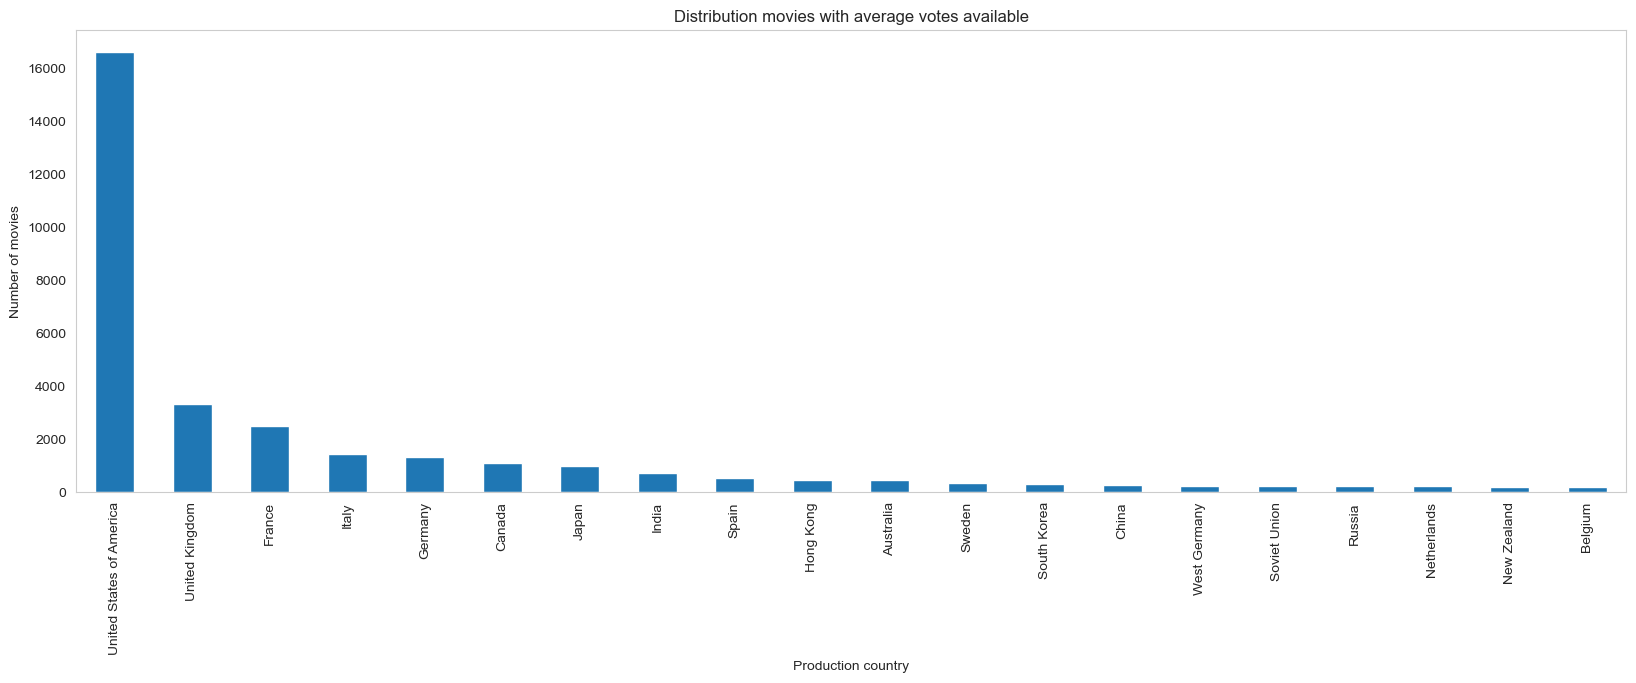

In [158]:
# Plot distribution of movies with an average vote
movies_with_vote = movie_copy.dropna(subset=['vote_average'])
plot_top_20_most_popular(movies_with_vote, 'Movie_countries', 'Production country', 'Number of movies',
                         'Distribution movies with average votes available')

Again the United States are still strongly represented when compared to other countries, however we observe that much more data about ratings are available for all countries compared to box office revenues enabling us to better judge how successful the movie was. There is more than two times more data available about ratings for France and the United Kingdom when compared to box office revenues. This is good news for our analysis since this will enable us to better see the affect of various factors on the movies success since we can now get a good idea of how successful each film was.

Let us take a look to the ratings in greater details. To be able to visualize our data, we will only keep the top 20 values of each feature we wish to visualize i.e. we consider the 20 most common production countries when talking about country. The same applies to movie genres when we will examine this feature and its relation with the production country.

In [159]:
# Duplicate movies with several production countries and genres
movies_expanded = movies_with_vote.explode('Movie_countries')
movies_fully_expanded = movies_expanded.explode('genres')

In [160]:
# Select the movies from the 20 most common production countries
top20_country = movies_fully_expanded['Movie_countries'].value_counts()[:20]
df_top20_country = movies_fully_expanded[movies_fully_expanded['Movie_countries'].isin(top20_country.index)]

Text(0, 0.5, 'Numbers of averge votes')

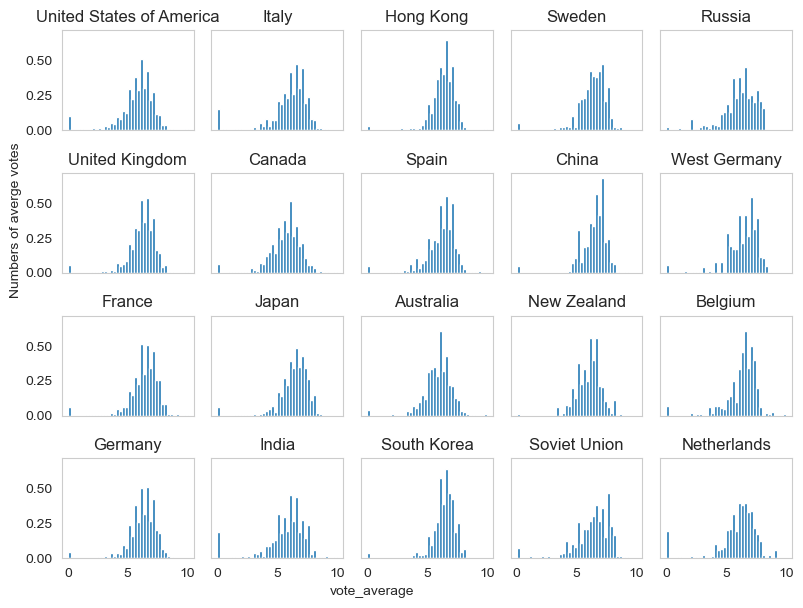

In [161]:
# Plot the distribution of the average votes for the top 20 countries
country = df_top20_country.groupby('Movie_countries')

fig, ax = plt.subplots(4, 5, figsize=(8, 6), sharey=True, sharex=True)

for i, name in enumerate(top20_country.index):
    sbplt = ax[i % 4, i // 4]
    sbplt.hist(country.get_group(name).vote_average, range=[0, 10], density=True, bins=40)
    sbplt.set_title(name)
    sbplt.grid(False)

fig.tight_layout()

fig.text(0.4, 0, "vote_average")
fig.text(0, 0.5, "Numbers of averge votes", rotation=90)

The different disrtibutions look nice, but it seems that there is an abnormal amount of average votes of 0 that does not match the rest of the distributions. An average vote equal to 0 for a movie is very unlikely and in our dataset we know that certain missing values for scalars are filled with 0. So, 0 average votes are more likely to be missing values rather than a true rating of 0. Let us remove rows containg such a values.

In [162]:
# Remove all average ratings equal to 0
movies_fully_expanded = movies_fully_expanded[movies_fully_expanded['vote_average'] != 0]

It is now time to proceed with the visualisation of our cleaned data  to confirm that they will enable us to answer this sub-question on the impact of the production countries over the movie success in our future analysis.

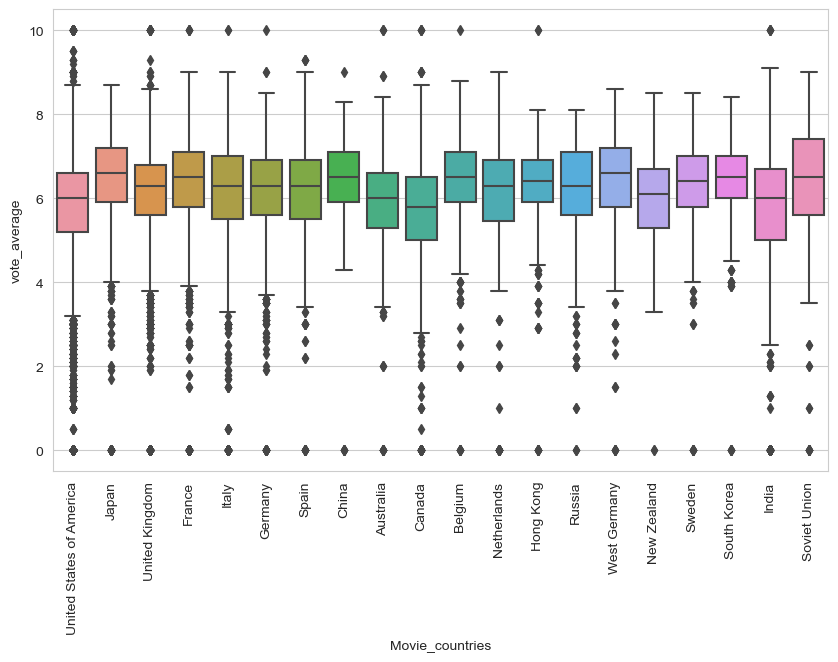

In [163]:
# Plot the distribution of the average votes
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Movie_countries", y="vote_average", data=df_top20_country)
plt.setp(ax.get_xticklabels(), rotation=90);

The distributions seems reasonable, but let us also consider the repartition of the rating among different genres for certain countries as it may differ from one country to another even if there over all rating distribution is similar.

In [164]:
# Select the movies whose genre is within the 20 most common genres (keeping movies from top 20 countries)
top20_genre = movies_fully_expanded['genres'].value_counts()[:20]
df_top20_genre_country = df_top20_country[df_top20_country['genres'].isin(top20_genre.index)]

In [165]:
# Select India, the United Kingdom and the US
df_top20_genre_india = df_top20_genre_country[df_top20_genre_country['Movie_countries'] == 'India']
df_top20_genre_uk = df_top20_genre_country[df_top20_genre_country['Movie_countries'] == 'United Kingdom']
df_top20_genre_american = df_top20_genre_country[
    df_top20_genre_country['Movie_countries'] == 'United States of America']

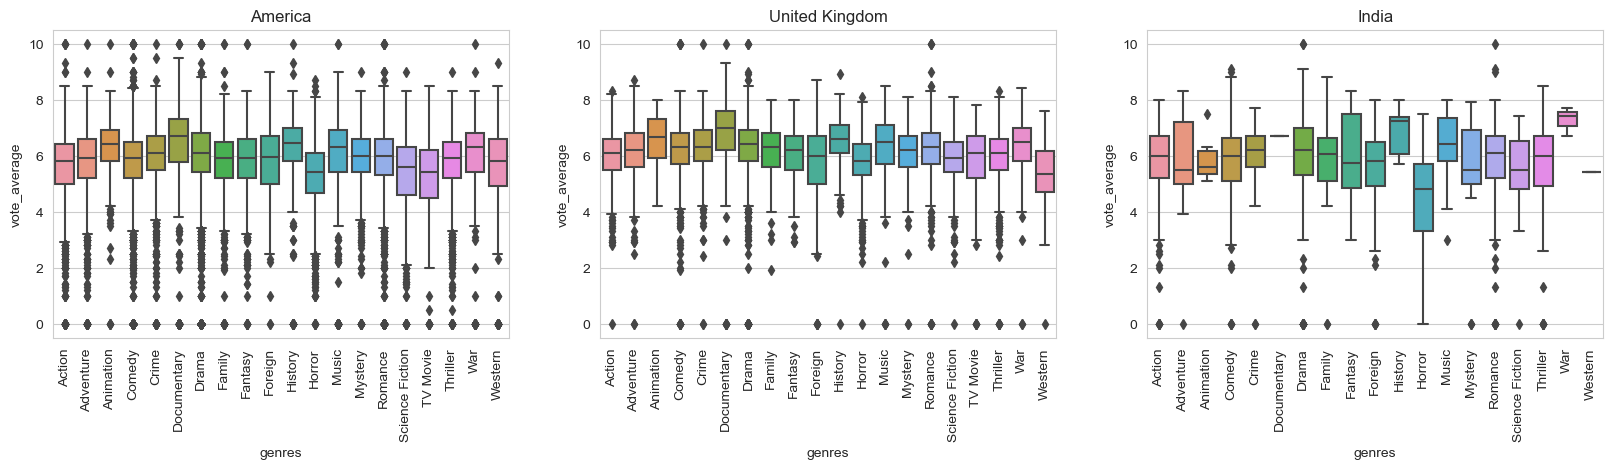

In [166]:
# Plot the distributions
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.title("America")
ax1 = sns.boxplot(x="genres", y="vote_average", data=df_top20_genre_american.sort_values(by='genres'))

plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x="genres", y="vote_average", data=df_top20_genre_uk.sort_values(by='genres'))
plt.title("United Kingdom")

plt.subplot(1, 3, 3)
ax3 = sns.boxplot(x="genres", y="vote_average", data=df_top20_genre_india.sort_values(by='genres'))
plt.title("India")

plt.setp(ax1.get_xticklabels(), rotation=90);
plt.setp(ax2.get_xticklabels(), rotation=90);
plt.setp(ax3.get_xticklabels(), rotation=90);

As one can observe the distributions for the ratings for the different genres are fairly comparable for United Kingdom and America that have similar cultures and national languages, but it differs a lot for India, even if the total average distribtions were comparable to the ones of the two other countries. This is notably because of a smaller amount of data available for the ratings on Indian movies. 

We will also probably have to consider the impact of the production country of a movie over its success given the genre of the movie whenever the amount of data permits it.

# Sub-Question 2: Relationship between movie genres and its success

In [167]:
# Separate the array of genres in every movie then group by the genres
movies_by_genre = movies.explode('genres').groupby('genres')

In [168]:
# Count the number of movies per genre then sort it
genre_count = movies_by_genre['Movie_name'].count().sort_values(ascending=False).reset_index()
genre_count = genre_count.rename(columns={'Movie_name': 'Movie Count'})
genre_count

,genres,Movie Count
0,Drama,13551
1,Comedy,8515
2,Thriller,5024
3,Romance,4950
4,Action,4709
5,Crime,3084
6,Horror,2993
7,Adventure,2584
8,Science Fiction,2098
9,Family,1950


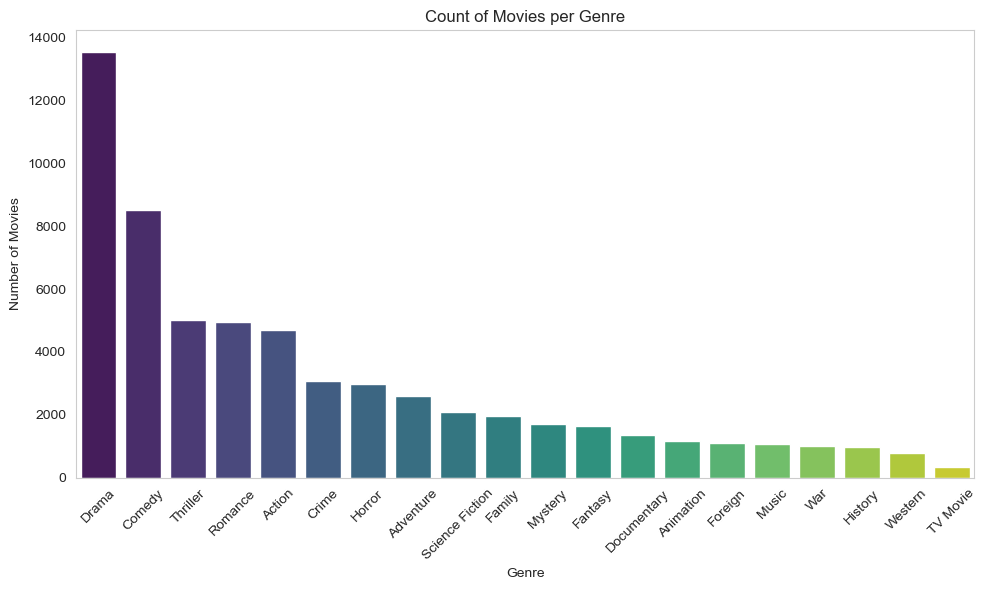

In [169]:
# Create a count plot
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.barplot(x='genres', y='Movie Count', data=genre_count, palette='viridis')
plt.title('Count of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

We can observe the distribution of movies across various genres. Among these genres, Drama emerges as the most prevalent, with an extensive count of 13,551 movies, suggesting its dominance in the dataset. It's closely followed by Comedy (8,515), Thriller (5,024), Romance (4,950), and Action (4,709), indicating their significant presence. Conversely, genres like TV Movie (335), Western (784), History (965), and War (1,007) have notably fewer movies, indicating a lesser representation within this dataset.

Genres with higher counts may denote broader appeal, while those with lower counts might cater to more niche audiences.
This set the question are the higher counts genres have the higher revenues ?

In [170]:
# Calculate the mean box office revenue per genre and then sort it
genre_revenue = movies_by_genre['Movie_box_office_revenue'].mean().sort_values(ascending=False).reset_index()
genre_revenue = genre_revenue.rename(columns={'Movie_box_office_revenue': 'Box Office mean revenue (in Millions $)'})

# Divide the revenue by 1 million
genre_revenue['Box Office mean revenue (in Millions $)'] /= 10 ** 6

genre_revenue

,genres,Box Office mean revenue (in Millions $)
0,Animation,140.942456
1,Adventure,124.999159
2,Fantasy,122.463366
3,Family,105.624014
4,Science Fiction,96.387734
5,Action,80.766886
6,Thriller,57.202198
7,Mystery,51.266550
8,Comedy,46.383952
9,Crime,46.356515


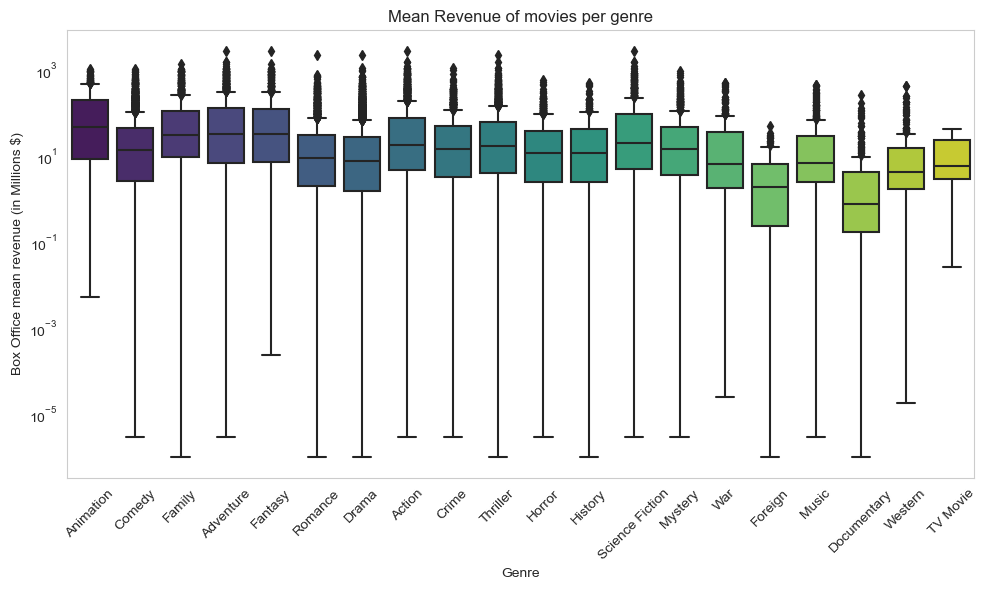

In [171]:
# Expand the genres of every movie to plot statistics
revenues = movies.explode('genres')[['genres', 'Movie_box_office_revenue']]
# Divide the revenue by 1 million
revenues['Movie_box_office_revenue'] /= 10 ** 6

# Create a revenue plot
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.boxplot(x='genres', y='Movie_box_office_revenue', data=revenues, palette='viridis')
plt.title('Mean Revenue of movies per genre')
plt.xlabel('Genre')
plt.ylabel('Box Office mean revenue (in Millions $)')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

The mean box office revenue by genres unveils intriguing insights about the financial performance of different genres within the dataset. While genres like Drama emerge as the most abundant, their average box office revenue of 32.56 million dollars indicates a moderate financial performance. In contrast, genres like Animation and Adventure display not only considerable movie counts but also boast significantly higher mean box office revenues of 140.94 million dollars and 125.00 million dollars respectively.

Lastly, let's try to analyze if the movies with the highest revenues are they the most profitable?


In [172]:
# Calculate the mean net profit of movies per genres and sort it in descending order
genre_profit = movies_by_genre['Net profit'].mean().sort_values(ascending=False).reset_index()
genre_profit = genre_profit.rename(columns={'Net profit': 'Box Office mean profit (in Millions $)'})

# Divide the profit by 1 million
genre_profit['Box Office mean profit (in Millions $)'] /= 10 ** 6

genre_profit

,genres,Box Office mean profit (in Millions $)
0,Animation,138.735040
1,Adventure,115.558414
2,Family,114.325613
3,Fantasy,110.250043
4,Science Fiction,79.185450
5,Action,72.473988
6,Comedy,48.074747
7,Thriller,46.070854
8,Mystery,43.340748
9,Music,41.599098


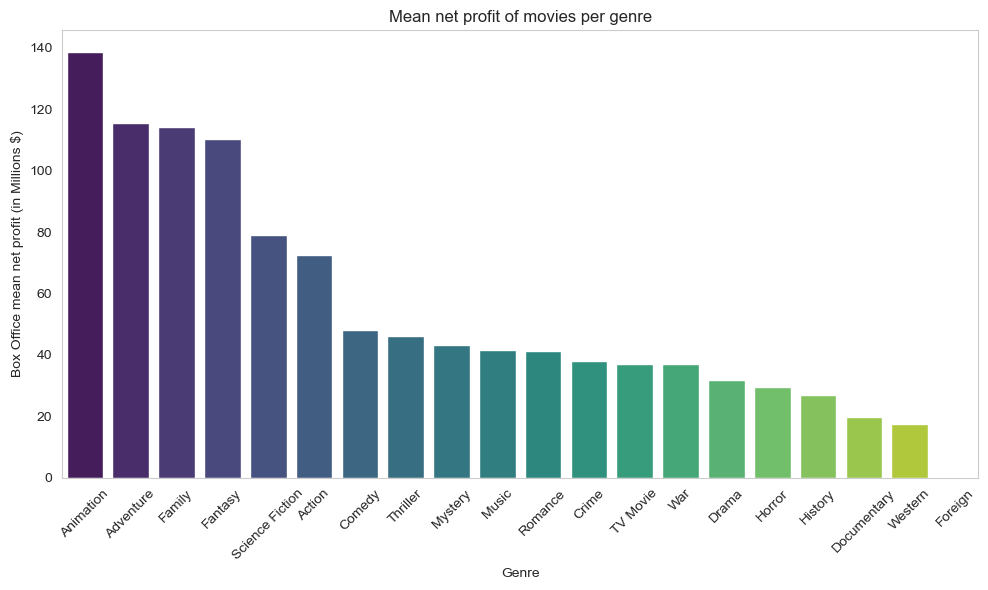

In [173]:
# Create a net profit plot
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.barplot(x='genres', y='Box Office mean profit (in Millions $)', data=genre_profit, palette='viridis')
plt.title('Mean net profit of movies per genre')
plt.xlabel('Genre')
plt.ylabel('Box Office mean net profit (in Millions $)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

The disparity observed between mean box office revenue and mean net profit across various movie genres reveals intriguing insights when considering movie budgets. Genres like Animation and Adventure exhibit higher mean box office revenues than their respective mean net profits by +2.20 million dollars and +9.44 million dollars respectively. Conversely, genres like Family and Science Fiction display a reverse trend, indicating mean net profits surpassing mean box office revenues by -8.71 million dollars and +17.20 million dollars respectively.

# Sub-Question 3: Does the period of release of a movie have an impact on its box office revenue?

In [29]:
movies_revenues = movies.copy().dropna(subset=['Movie_box_office_revenue']).reset_index(drop=True)
print(f"The number of movies with box office revenue is : {len(movies_revenues)}")

The number of movies with box office revenue is : 9147


*Let's analyze the distributions of the 9147 movies*

### Year distribution and its relationship with the box office revenue

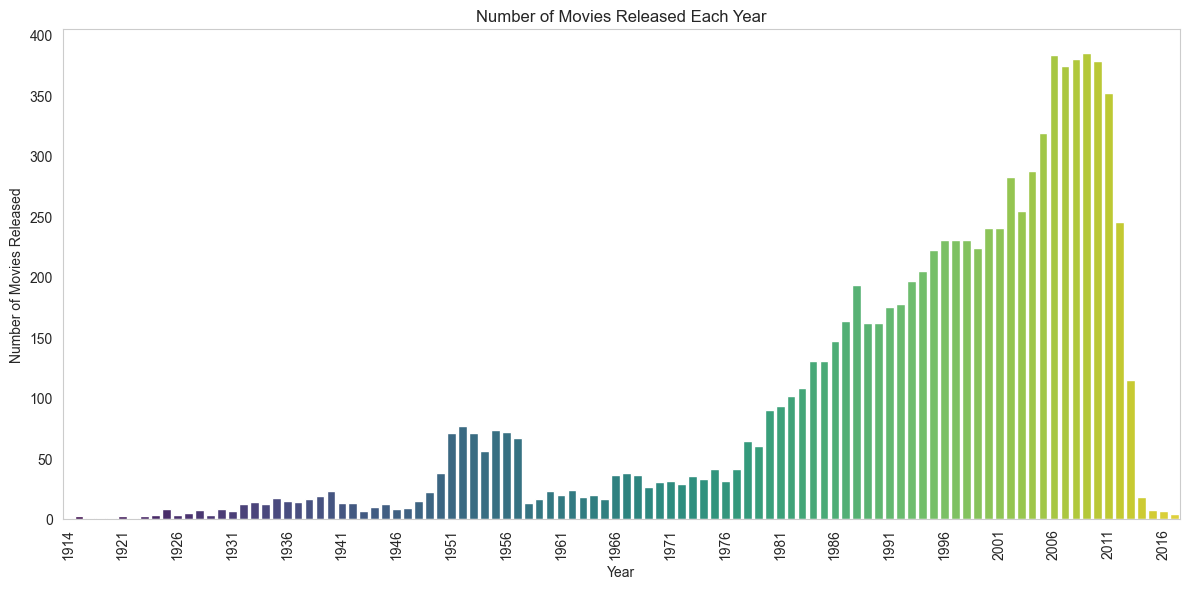

In [30]:
# Calculate the number of movies released each year and sort the data by year.
yearly_counts = movies_revenues['year'].value_counts().sort_index()

# Set up the figure size and the style for better clarity and aesthetics.
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Create a bar plot to show the number of movies released each year using the 'viridis' color palette for visibility.
# The 'hue' parameter assigns a different shade to each bar, making each year distinct.
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='viridis')

# Generate tick labels that only label every 5 years to avoid cluttering the x-axis.
tick_labels = [str(year) if i % 5 == 0 else '' for i, year in enumerate(yearly_counts.index)]
plt.xticks(ticks=np.arange(len(yearly_counts.index)), labels=tick_labels, rotation=90)

# Label the x-axis and y-axis for clarity.
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')

# Add a title to the plot for better context.
plt.title('Number of Movies Released Each Year')

# Set 'plt.grid(False)' to remove the grid for a cleaner look.
plt.grid(False)

# Remove the legend since it is unnecessary after assigning colors to each bar.
plt.legend([], [], frameon=False)

# Ensure the plot is displayed well without overlapping elements.
plt.tight_layout()
plt.show()

*This histogram displays the count of movies released annually, revealing a clear upward trend in the film industry's output. The growth becomes more pronounced in recent decades, indicating a significant expansion in movie production.*

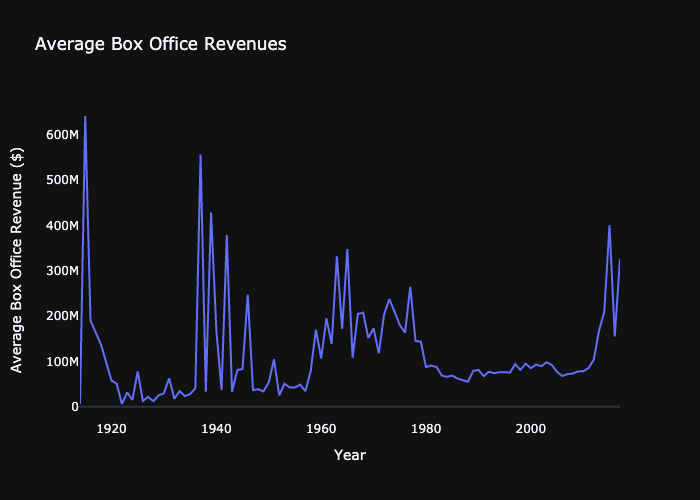

In [31]:
# Aggregating yearly data for analysis
yearly_stats = movies_revenues.groupby('year').apply(
    lambda df: pd.Series({
        'avg_box_office_revenue': df['Movie_box_office_revenue'].mean(),  # Calculate the average revenue per year
    })
)

# Creating a scatter plot trace for average revenue over the years
average_revenue_trace = go.Scatter(
    x=yearly_stats.index,  # X-axis: years
    y=yearly_stats['avg_box_office_revenue'],  # Y-axis: average box office revenue
    mode='lines',  # Line plot
    name='Average Box Office Revenue'  # Legend name
)

# Defining the layout of the plot
plot_layout = go.Layout(
    title='Average Box Office Revenues',  # Title of the plot
    xaxis=dict(
        title='Year',  # X-axis title
        tickmode='auto',  # Automatic ticks
        showgrid=False  # Hide gridlines
    ),
    yaxis=dict(
        title='Average Box Office Revenue ($)',  # Y-axis title
        showgrid=False  # Hide gridlines
    ),
    hovermode='closest'  # Show the closest data point on hover
)

# Creating the figure with the trace and layout
yearly_trends_figure = go.Figure(data=[average_revenue_trace], layout=plot_layout)
yearly_trends_figure.write_image("images/line_plot.png")
# Display the figure
display(Image("images/line_plot.png"))

### Month distribution and its relationship with the box office revenue

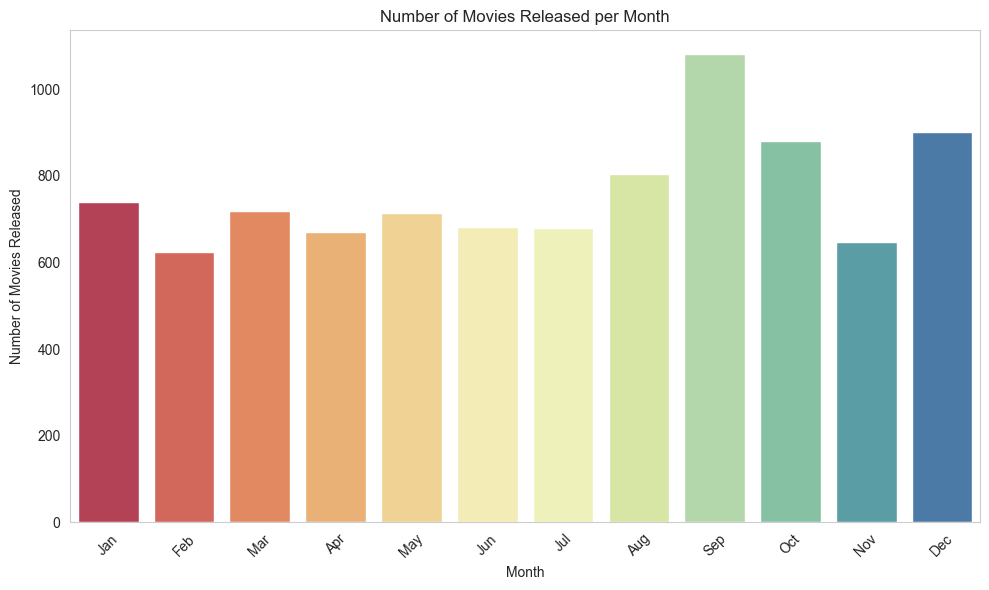

In [32]:
# Group movies by month and count the number of movies released each month
monthly_counts = movies_revenues.groupby('month').size()

# Set up the figure size for the plot
plt.figure(figsize=(10, 6))

# Apply a white grid style for the plot background
sns.set_style('whitegrid')

# Create a bar plot to show the number of movies released each month, using a 'Spectral' color palette for better visualization
# Use 'hue' to assign different colors to each bar
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='Spectral', dodge=False)

# Set the x-ticks and labels to display all months and rotate them for better readability
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], rotation=45)

# Label the x-axis and y-axis
plt.xlabel('Month')
plt.ylabel('Number of Movies Released')

# Add a title to the plot
plt.title('Number of Movies Released per Month')

# Remove the grid from the plot for a cleaner look
plt.grid(False)

# Remove the legend as it is unnecessary in this context
plt.legend([], [], frameon=False)

# Adjust the plot layout to make sure everything fits well
plt.tight_layout()
plt.show()

*This bar chart shows the number of movies released each month. We see the highest releases in September and October, indicating a possible preference for launching films during fall season.*

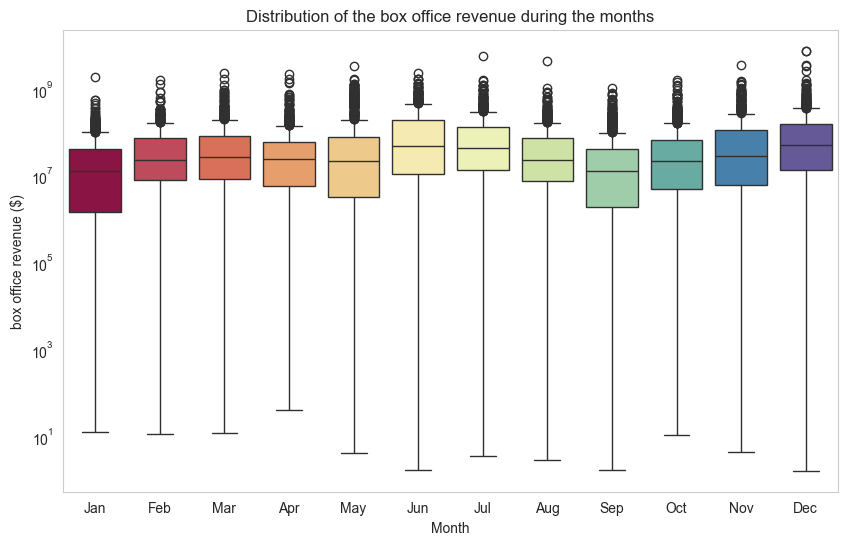

In [33]:
# Set the style of the plot to 'whitegrid' for a clean background with grid lines
sns.set_style('whitegrid')

# Set the size of the figure for the plot
plt.figure(figsize=(10, 6))

# Create a box plot to show the distribution of box office revenue across different months
# Use the 'Spectral' palette to assign colors to each month and disable the dodge option
sns.boxplot(x="month", y="Movie_box_office_revenue", hue="month",
            data=movies_revenues, palette='Spectral', dodge=False)

# Set the x-ticks to display all months and label them accordingly
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Title the plot to describe what it is showing
plt.title("Distribution of the box office revenue during the months")

# Label the x-axis as "Month" and y-axis as "box office revenue ($)"
plt.xlabel("Month")
plt.ylabel("box office revenue ($)")

# Set the y-axis scale to logarithmic to better display the wide range of values
plt.yscale("log")

# Remove the grid for a cleaner appearance
plt.grid(False)

# Remove the legend because the colors are already explained in the x-axis labels
plt.legend([], [], frameon=False)
plt.show()

*This box plot visualizes the spread of monthly box office revenues, highlighting the variability within each month. The logarithmic scale captures the wide range of revenues, from modest to blockbuster hits.*

### Day distribution and its relationship with the box office revenue

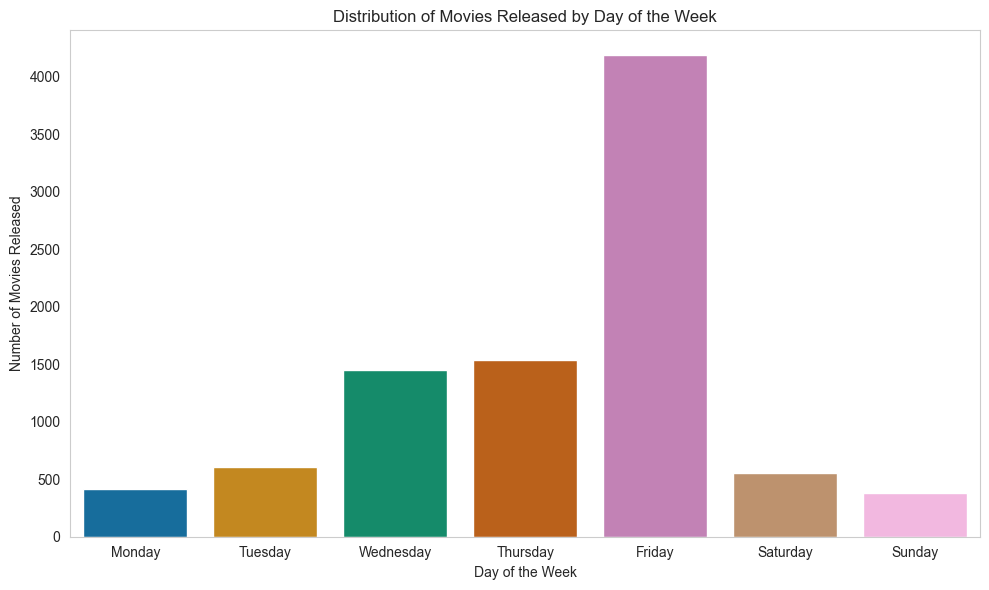

In [34]:
# Define the correct order of days in the week
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group movies by day of the week and count the number of movies released each day
day_counts = movies_revenues.groupby('day_week').size()

# Reorder the 'day_counts' series according to the predefined order of 'ordered_days' to maintain logical sequencing in the plot
day_counts = day_counts.loc[ordered_days]

# Set up the figure size for the bar plot
plt.figure(figsize=(10, 6))

# Apply a white grid style for the plot background to enhance readability and aesthetics
sns.set_style('whitegrid')

# Create a bar plot to visualize the number of movies released on each day of the week
# 'colorblind' palette is used to assist viewers with color vision deficiencies
# 'dodge' set to 'False' to avoid shifting the bars and maintain a consistent layout
sns.barplot(x=day_counts.index, y=day_counts.values, palette='colorblind', hue=day_counts.index, dodge=False)

# Label the x-axis 'Day of the Week' and the y-axis 'Number of Movies Released' for clarity
plt.xlabel('Day of the Week')
plt.ylabel('Number of Movies Released')

# Add a title to the bar plot to provide context
plt.title('Distribution of Movies Released by Day of the Week')

# Disable the grid lines on the plot for a cleaner look
plt.grid(False)
# Remove the legend because the colors are already explained in the x-axis labels
plt.legend([], [], frameon=False)

# Adjust the layout of the plot to ensure it is well-organized and elements are displayed properly
plt.tight_layout()
plt.show()

*This bar chart shows the number of movies released on each day of the week. Friday is the most popular day for movie releases, with significantly fewer movies coming out at the start of the week.*

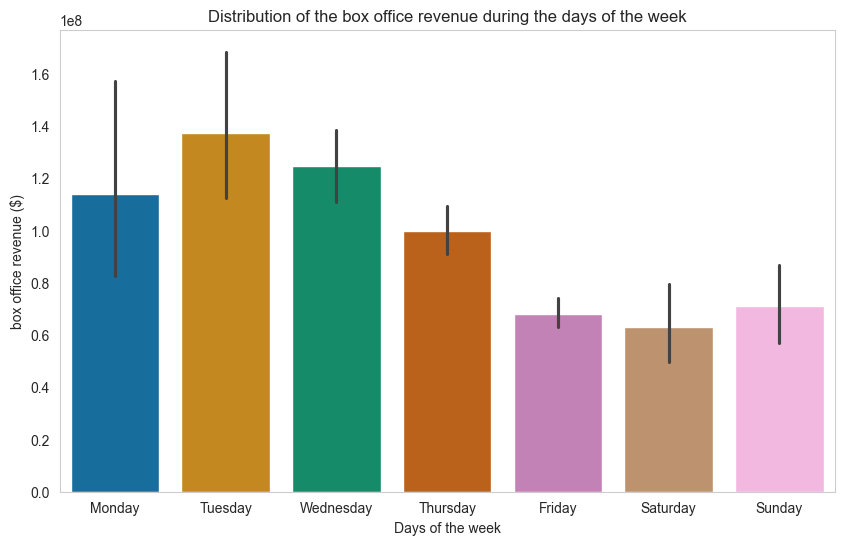

In [35]:
# Define a dictionary to map the days of the week to a numerical order, with Monday as 0 and Sunday as 6.
day_order = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# Apply the 'day_order' dictionary to create a new 'day_order' column,
# which assigns each day of the week its corresponding numerical order for sorting purposes.
movies_revenues['day_order'] = movies_revenues['day_week'].apply(lambda x: day_order[x])

# Sort the DataFrame based on the 'day_order' column to ensure the data is ordered from Monday to Sunday.
movies_revenues.sort_values('day_order', inplace=True)

plt.figure(figsize=(10, 6))

# Set the plotting style to 'whitegrid' which adds grid lines for better readability of the plot.
sns.set_style('whitegrid')

# Create a barplot that shows the box office revenue distribution across different days of the week.
# The 'colorblind' palette is used to ensure the plot is accessible to individuals with color vision deficiencies.
# The 'dodge' parameter is set to 'False' to keep the bars for each day aligned without any offset.
sns.barplot(x="day_week", y="Movie_box_office_revenue", hue="day_week",
            data=movies_revenues, palette='colorblind', dodge=False)

# Add a title to the plot for better context.
plt.title("Distribution of the box office revenue during the days of the week")

# Label the x-axis as 'Days of the week' and the y-axis as 'box office revenue ($)'.
plt.xlabel("Days of the week")
plt.ylabel("box office revenue ($)")

# Remove the legend because the colors are already explained in the x-axis labels
plt.legend([], [], frameon=False)

# Disable grid lines on the plot for a cleaner appearance.
plt.grid(False)
plt.show()

*This bar chart illustrates the box office revenue generated on each day of the week. Mid-week days, particularly Tuesday and Wednesday, show a higher median revenue compared to the beginning and end of the week. The wide range of revenues indicated by the error bars suggests there is significant variability in box office success from day to day.*

**After observing how box office revenues vary with the release year, month, and day, it's clear that the release date might affect a film's success. These initial observations give us a good overview, but to truly understand and predict these patterns, we need to investigate further. Let's now delve into a detailed statistical analysis to uncover the deeper relationships between release dates and box office performance.**

### Statistical Analysis

#### **1- Yearly Analysis**

In [36]:
# correlation between year and revenue
stats.spearmanr(movies_revenues['year'], movies_revenues["Movie_box_office_revenue"])

SignificanceResult(statistic=-0.11897114136274298, pvalue=3.422896287362038e-30)

**Statistical Analysis Summary:**  
- The analysis reveals a weak yet statistically significant negative correlation between the movie release year and the inflation-adjusted box office revenue. This is highlighted by a Spearman correlation coefficient of approximately -0.119 and a p-value near zero. The findings suggest a trend where more recent films tend to earn slightly lower revenues when adjusted for inflation, indicating a subtle but notable shift in the movie industry's financial landscape.

**Conclusion:**
- The release year has a minor impact on the movie's box office revenue

**Having identified only a slight influence of release year on box office revenue, attention now turns to the monthly release patterns. This next phase of analysis will investigate whether specific months yield higher revenues, potentially uncovering seasonal trends or periodic market dynamics that could inform optimal release timing for films.**

#### 2- Monthly Analysis

In [37]:
# Perform ANOVA across months
# First, we need to aggregate the revenues by month
grouped_data = movies_revenues.groupby('month')['Movie_box_office_revenue'].apply(list)

# Perform the ANOVA test using the f_oneway function from scipy.stats
anova_result = f_oneway(*grouped_data)
print(anova_result)

F_onewayResult(statistic=25.6551305460284, pvalue=3.6049946325215933e-53)


**ANOVA Test Summary:**  
- The ANOVA test revealed a significant F-statistic of 25.655 and a p-value of approximately  $3.60 \times 10^{-53}$ , indicating a strong statistical difference in average box office revenues across various months. This suggests that the month of release plays a substantial role in influencing a film's financial outcomes. Given the notable variation in revenue by month, further post-hoc analysis is essential to elucidate the specific months that contribute to this effect, providing valuable insights for strategic planning in the movie industry.


**Following the significant findings from the ANOVA test, the next logical step is to conduct a detailed examination of each month's individual impact on movie revenues. This requires a closer look into pairwise comparisons to pinpoint which months are statistically significant from the others in terms of box office performance. The following code blocks apply t-tests to contrast each month against the collective performance of the others, offering a granular view of monthly trends. The results from this analysis will not only determine the best month for film release but also illustrate the comparative financial landscape across the calendar year.**



###### **Creation of months mapping**

In [38]:
# Mapping of month numbers to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Add a new column for month names
movies_revenues['month_name'] = movies_revenues['month'].map(month_names)

# Get unique months in the dataset
unique_months = movies_revenues['month'].unique()

###### **Pairwise T-Test Analysis: Monthly Revenue Comparison**

In [39]:
# Initialize a list to store the t-test results
t_test_results = []

# Perform t-tests between each month and the rest
for month in sorted(unique_months):  # Sort the months
    # Revenue for the selected month
    current_month_revenue = movies_revenues.loc[movies_revenues['month'] == month, 'Movie_box_office_revenue']
    
    # Revenue for all other months
    other_months_revenue = movies_revenues.loc[movies_revenues['month'] != month, 'Movie_box_office_revenue']
    
    # Perform the t-test
    t_stat, p_val = stats.ttest_ind(current_month_revenue, other_months_revenue, equal_var=False)
    
    # Append the results
    t_test_results.append({
        'month': month,
        'month_name': month_names[month],  # Get the month name
        't_statistic': t_stat,
        'p_value': p_val
    })

###### **Data Aggregation and Significance Assessment: Identifying the Best Month for Releases**

In [40]:
# Convert the results into a DataFrame and sort by 'month' to ensure correct order
t_test_results_df = pd.DataFrame(t_test_results).sort_values(by='month')

# Adjust p-values for multiple testing
t_test_results_df['adjusted_p_value'] = np.minimum(t_test_results_df['p_value'] * len(unique_months), 1.0)

# Identify the best month by the highest t-statistic and significant p-value
best_month = t_test_results_df.loc[t_test_results_df['adjusted_p_value'] < 0.05].sort_values(by='t_statistic', ascending=False)['month'].values[0]
best_month_name = month_names[best_month]

###### **Visualizing Monthly Revenue Trends: Highlighting the Optimal Release Window**

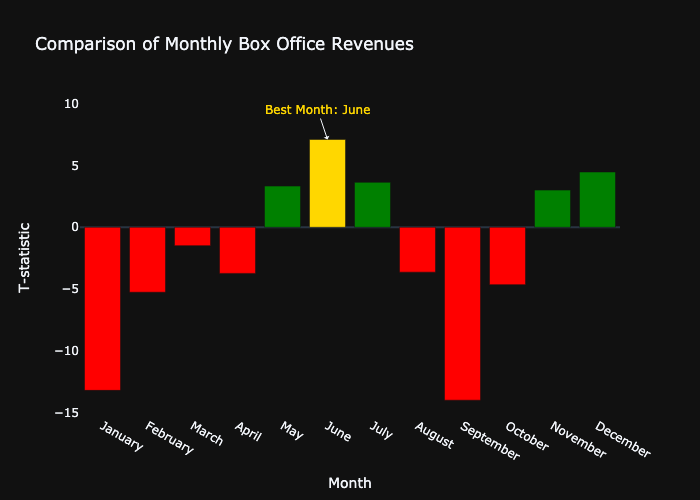

In [41]:
# Create traces for the interactive plot
traces = []
for _, row in t_test_results_df.iterrows():
    color = 'gold' if row['month'] == best_month else ('red' if row['t_statistic'] < 0 else 'green')
    traces.append(go.Bar(
        x=[row['month_name']],  
        y=[row['t_statistic']],
        marker_color=color
    ))

# Create the layout for the plot
layout = go.Layout(
    title='Comparison of Monthly Box Office Revenues',
    xaxis=dict(title='Month', type='category'),  # Set x-axis as category to maintain month order
    yaxis=dict(title='T-statistic', showgrid=False),
    showlegend=False,
    barmode='group'
)

# Combine the traces in a figure
fig = go.Figure(data=traces, layout=layout)

# Add annotation for the best month
fig.add_annotation(
    x=best_month_name,
    y=t_test_results_df.loc[t_test_results_df['month'] == best_month, 't_statistic'].iloc[0],
    text=f"Best Month: {best_month_name}",
    showarrow=True,
    arrowhead=1,
    font=dict(color="gold")
)
fig.write_image("images/bar_plot.png")
# Show the figure
display(Image("images/bar_plot.png"))

#### Monthly Box Office Analysis Summary :

- Our analysis identifies **June** as the prime month for movie releases, with **December** following closely behind. This trend is likely influenced by summer and end-of-year holiday seasons, periods when movie-going is traditionally more popular due to vacations.

- The t-test comparison across months confirms that June, coinciding with summer vacations, exhibits the highest positive difference in box office revenues. Similarly, December benefits from the festive **Noel holiday season**, making it the second most lucrative month for film debuts.

- These insights suggest that timing movie releases to coincide with major vacation periods can significantly enhance box office performance.


### Having discerned the significant monthly patterns in box office revenue, with June and December standing out as peak periods, we now pivot our focus to a more granular scale. The daily analysis will delve into the question of whether specific days of the week influence box office success. This step could unveil daily trends that might sharpen the strategic timing of movie releases

#### 3- Daily Analysis

###### **Data Preparation and Encoding**

In [42]:
# Encoding days of the week and genres
encoded_days = pd.get_dummies(movies_revenues['day_week']).astype(int)
genre_binarizer = MultiLabelBinarizer()
encoded_genres = genre_binarizer.fit_transform(movies_revenues['genres'])
encoded_genres_df = pd.DataFrame(encoded_genres, columns=genre_binarizer.classes_)

# Combining encoded features with revenue data
combined_data = pd.concat([movies_revenues['Movie_box_office_revenue'], encoded_days, encoded_genres_df], axis=1)
combined_data['day_week'] = movies_revenues['day_week']  # Including original day names for mean analysis

###### **Calculation of Average Revenue per Day and Genre**

In [43]:
# DataFrame for storing average revenue per day and genre
average_revenue = pd.DataFrame(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], columns=genre_binarizer.classes_)
for day in average_revenue.index:
    for genre in average_revenue.columns:
        genre_day_data = combined_data[(combined_data[day] == 1) & (combined_data[genre] == 1)]
        average_revenue.at[day, genre] = genre_day_data['Movie_box_office_revenue'].mean()

# Filling NaN values with zero
average_revenue.fillna(0, inplace=True)

###### **Best Release Day Analysis for Each Genre**

In [44]:
# Dictionaries for storing best release days
best_days_rf = {}  # Best days as per Random Forest model
best_days_mean = {}  # Best days as per mean analysis
best_days_final = {}  # Final selected best days
discrepancies = []  # Genres with discrepancies between models

# Analyzing best release day for each genre
for genre in encoded_genres_df.columns:
    genre_specific_data = combined_data[combined_data[genre] == 1]
    features = genre_specific_data[encoded_days.columns]
    target = genre_specific_data['Movie_box_office_revenue']

    # Mean analysis for best day
    best_day_mean_analysis = average_revenue[genre].idxmax()
    best_days_mean[genre] = best_day_mean_analysis

    # Random Forest model analysis
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
    random_forest_model.fit(features, target)
    feature_importances = random_forest_model.feature_importances_
    best_day_rf = encoded_days.columns[feature_importances.argmax()]
    best_days_rf[genre] = best_day_rf

    # Selecting the final best day and tracking discrepancies
    if best_day_rf == best_day_mean_analysis:
        best_days_final[genre] = best_day_rf
    else:
        discrepancies.append(genre)
        best_days_final[genre] = best_day_mean_analysis

# Reporting discrepancies
print("Genres with discrepancies between models:", discrepancies)

Genres with discrepancies between models: ['Comedy', 'Horror', 'Mystery', 'Romance', 'Science Fiction']


###### **Heatmap Visualization of Average Revenue and Best Release Days**

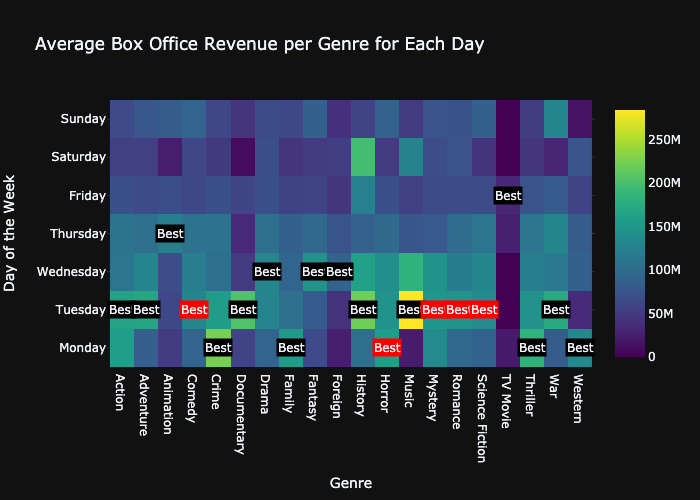

In [45]:
# Creating a heatmap to visualize average revenue per day and genre
heatmap_fig = go.Figure(data=go.Heatmap(
                            z=average_revenue,
                            x=average_revenue.columns,
                            y=average_revenue.index,
                            colorscale='Viridis',
                            hovertemplate='Genre: %{x}<br>Day: %{y}<br>Average: %{z:,.2f} $<extra></extra>'
                        ))

# Annotations for best release days
for genre in genre_binarizer.classes_:
    best_day = best_days_final[genre]
    annotation_color = "red" if genre in discrepancies else "black"
    heatmap_fig.add_annotation(x=genre, y=best_day, text="Best", showarrow=False, bgcolor=annotation_color)

# Updating layout for better readability
heatmap_fig.update_layout(
    title='Average Box Office Revenue per Genre for Each Day',
    xaxis_nticks=36,
    yaxis_nticks=36,
    xaxis_title='Genre',
    yaxis_title='Day of the Week'
)
heatmap_fig.write_image("images/heat_map.png")
# Displaying the heatmap
display(Image("images/heat_map.png", width=2000))

#### Daily Box Office Revenue Analysis Summary:

- In our analysis, we systematically processed and examined the box office revenue data across different days of the week for various movie genres. We started by encoding the days and genres into a machine-readable format using one-hot encoding, which transformed categorical data into numerical. This enabled us to apply a Random Forest regression model to estimate the relative importance of each day of the week for the box office success of movies within each genre.

- Additionally, we conducted a mean revenue analysis to observe the average box office earnings by genre for each day. The comparison of findings from the Random Forest model and the mean revenue analysis occasionally revealed differences. In such cases, we leaned on the mean revenue figures as the more reflective measure of historical performance.

- The culmination of our analysis was presented in a heatmap, which intuitively displayed the average revenues, allowing for a quick visual assessment of the best release days per genre. This comprehensive approach ensured a robust and data-driven strategy for identifying the optimal days for movie releases, tailored to the nuances of genre-specific audience behaviors.

## Summary of Box Office Revenue Analysis
- In our comprehensive analysis, we investigated how the timing of a movie's release influences its box office success, considering yearly trends, monthly patterns, and daily fluctuations.

### Yearly Trends
- Our findings indicate a slight but consistent trend where more recent movies tend to earn marginally lower revenues when adjusted for inflation, hinting at evolving market dynamics within the film industry.

### Optimal Months for Movie Releases
- The analysis pinpoints **June** as the optimal month for movie releases, closely followed by **December**. This pattern can be attributed to the increased audience turnout during the summer and winter holiday seasons, respectively.

### Daily Box Office Performance
- A granular examination of daily box office revenues, segmented by movie genres, was conducted using both a Random Forest regression model and a mean revenue analysis. In instances of discrepancy between the two methods, the mean revenue analysis, which directly reflects historical performance, was deemed more reliable.

- The insights culminate in a heatmap visualization that succinctly depicts average revenues, facilitating a quick visual grasp of the most lucrative release days per genre. This strategic, data-driven approach is designed to optimize release schedules in alignment with genre-specific audience preferences.


# Sub-Question 4: Relationship between the cast characters and the movie success

In this section, we aim to explore the feasability of the study focusing on the relationship between a movie's cast and its success in terms of ratings and box office revenues. The aim of this study will be to analyse the relationship between the success of a movie and the number of its actors, their gender repartition, their diversity, etc...

In [185]:
characters.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


We are not going to use the Wikipedia movie id, so let us discard it.

In [186]:
characters = characters.drop('Wikipedia_Movie_ID', axis=1)

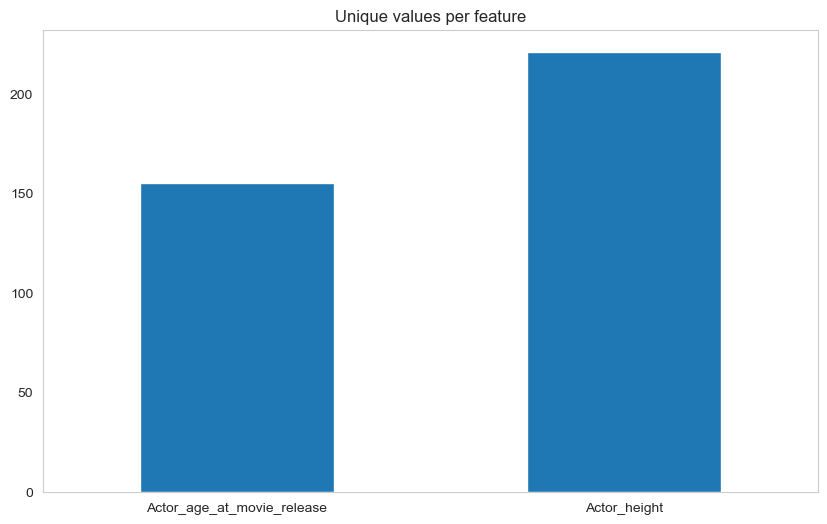

In [187]:
structural_analysis(characters)

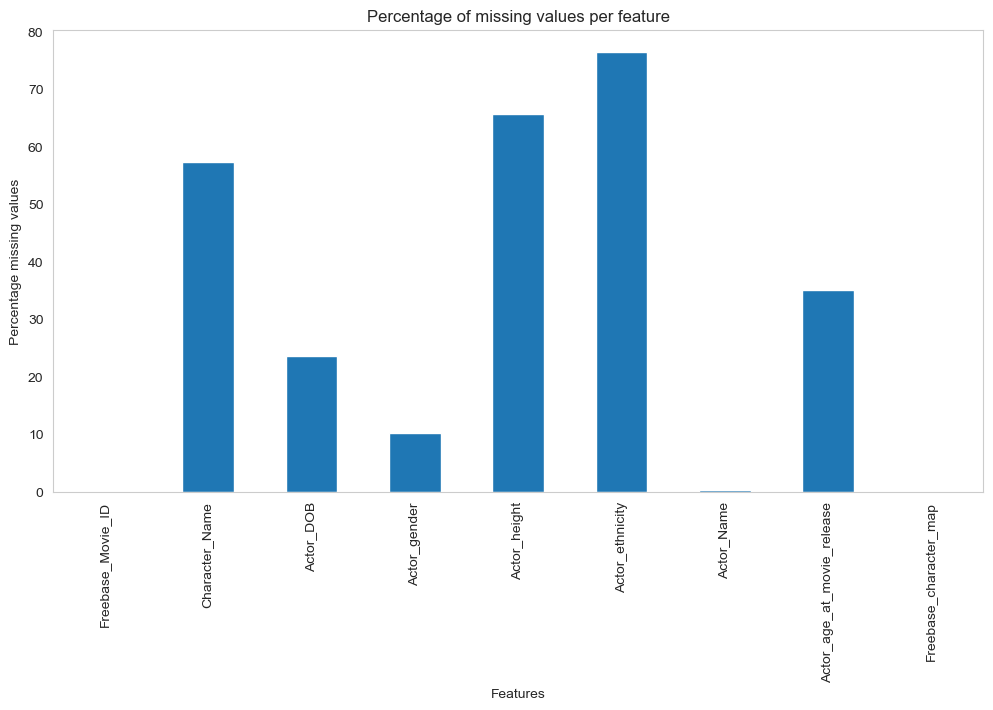

In [188]:
plot_nan(characters, 'Percentage of missing values per feature')

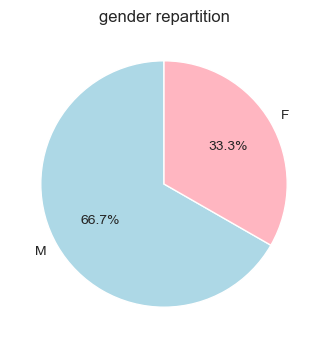

In [189]:
# Counting how many characters of each gender are there
gender_counts = characters['Actor_gender'].value_counts()

# Creating a pie chart
plt.figure(figsize=(4, 4))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'])
plt.title('gender repartition')
plt.show()

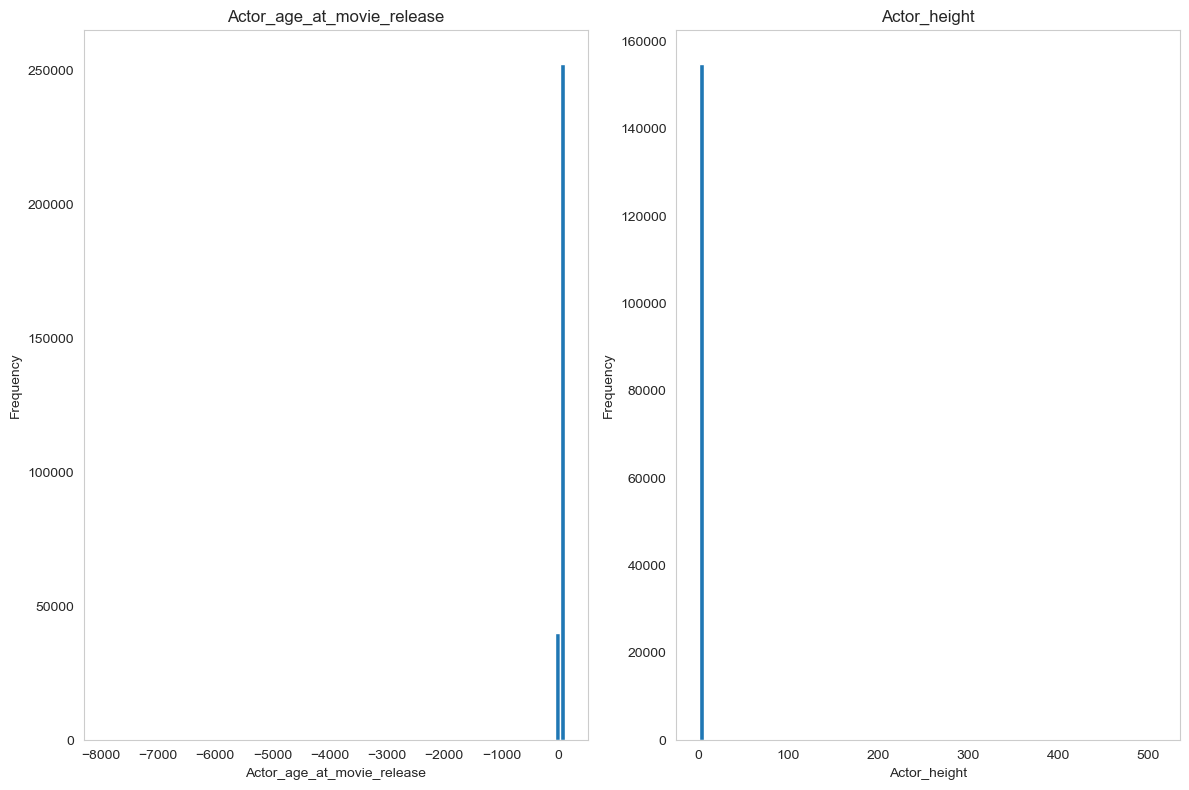

In [190]:
plot_histograms(characters, ['Actor_age_at_movie_release', 'Actor_height'])

We can see that there are some outliers in our data frame, let us remove them and replot them


In [191]:
# We remove from characters the characters at indices that satisfy both the outliers conditions
condition1 = characters['Actor_age_at_movie_release'] < 0
condition2 = characters['Actor_height'] >= 3
characters = characters.drop(characters[condition1].index)
characters = characters.drop(characters[condition2].index)

/var/folders/my/z865vhpd7nq1j64xqjllt3f00000gn/T/ipykernel_9043/632332126.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  characters = characters.drop(characters[condition2].index)


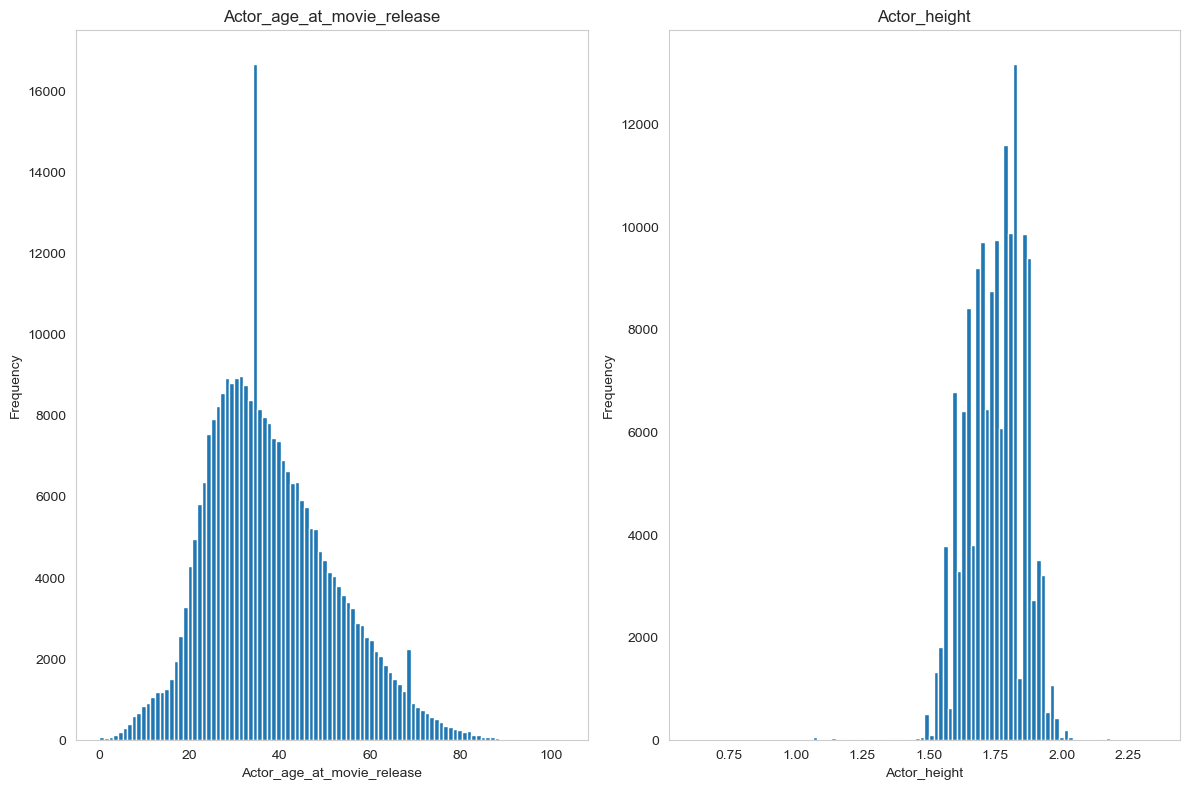

In [192]:
plot_histograms(characters, ['Actor_age_at_movie_release', 'Actor_height'])

We observe that the distributions of the actor ages and heights are much better after the removal of the outliers.

Now, let us see the distribution of the number of actors per movie, meaning, for each movie with a freebase movie id, the number of occurencies of that freebase movie id in the characters dataframe.

In [193]:
# characters that have a corresponding movie in movies
characters_in_movies = characters[characters['Freebase_Movie_ID'].isin(movies['Freebase_Movie_ID'])]

In [194]:
percentage = (len(characters_in_movies) / len(characters))
print(f"the percentage of charcaters that are represented in a movie of our dataset of movies is : {percentage:.2%}")

the percentage of charcaters that are represented in a movie of our dataset of movies is : 54.73%


We see that from our characters dataset, we can use a good portion of it to study the relationship between the casting of a movie and it's box office revenue since 55% of the characters are in one of the movies of our dataset, which is considerable given the size of our dataset.

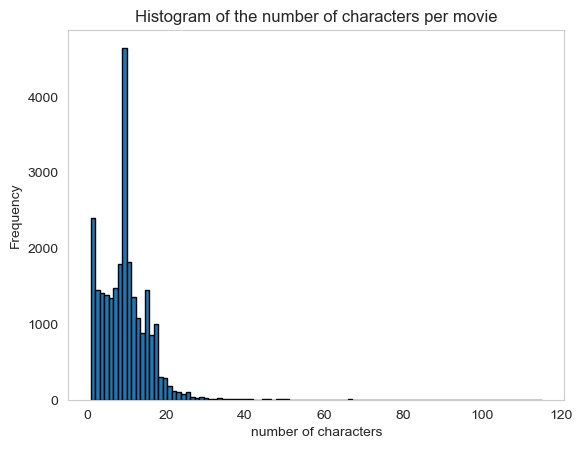

In [195]:
# Number of characters per each movie
characters_per_movie = characters_in_movies.groupby('Freebase_Movie_ID').size()
characters_per_movie.plot(kind='hist', bins=100, edgecolor='black')

plt.title('Histogram of the number of characters per movie')
plt.xlabel('number of characters')
plt.ylabel('Frequency')
plt.grid(False)

# Show the plot
plt.show()

Let us add the number of actors featured in a movie to the movies dataframe.

In [196]:
# merging the number of characters per movie into movies dataframe 
characters_per_movie.name = 'number_of_actors'
movies = movies.merge(characters_per_movie, left_on="Freebase_Movie_ID", right_index=True)

In [197]:
movies.describe()

,budget,Movie_box_office_revenue,Net profit,popularity,Movie_runtime,vote_average,vote_count,number_of_actors
count,6.545000e+03,8.982000e+03,4.982000e+03,25735.000000,24784.000000,25746.000000,25746.000000,25746.000000
mean,2.343598e+07,4.959183e+07,5.083928e+07,3.559066,101.307002,5.846077,141.579779,9.571079
std,3.391890e+07,1.158964e+08,1.246617e+08,4.593772,27.330694,1.523681,548.384005,5.796700
min,1.000000e+00,1.000000e+00,-1.657101e+08,0.000001,0.000000,0.000000,0.000000,1.000000
25%,3.000000e+06,2.200000e+06,-1.962628e+06,0.651756,90.000000,5.300000,5.000000,5.000000
50%,1.080000e+07,1.120574e+07,9.044629e+06,1.716467,98.000000,6.100000,15.000000,9.000000
75%,3.000000e+07,4.203257e+07,5.315675e+07,5.436386,110.000000,6.800000,54.000000,13.000000
max,3.800000e+08,2.782275e+09,2.545275e+09,185.070892,1003.000000,10.000000,14075.000000,115.000000


Let us take a look at the fraction of female actors for each movie

In [198]:
male_characters = characters[characters['Actor_gender'] == 'M']
number_of_male_actors = male_characters.groupby('Freebase_Movie_ID').size()

female_characters = characters[characters['Actor_gender'] == 'F']
number_of_female_actors = female_characters.groupby('Freebase_Movie_ID').size()

fraction_of_female_actors = 100 * (number_of_female_actors / characters_per_movie)

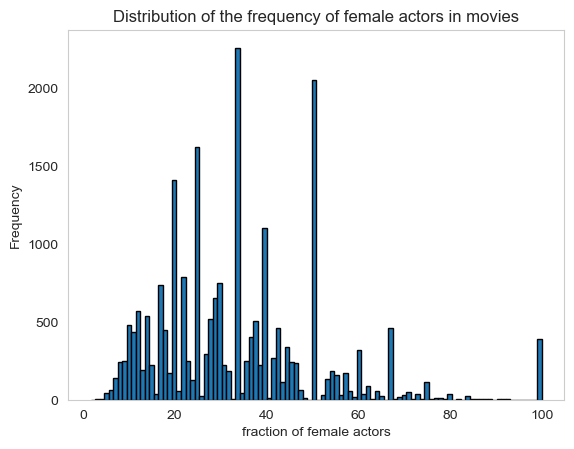

In [199]:
fraction_of_female_actors.plot(kind='hist', bins=100, edgecolor='black')

plt.title('Distribution of the frequency of female actors in movies')
plt.xlabel('fraction of female actors')
plt.ylabel('Frequency')
plt.grid(False)

# Show the plot
plt.show()

In [200]:
fraction_of_female_actors.name = 'fraction_of_female_actors'
movies = movies.merge(fraction_of_female_actors, left_on="Freebase_Movie_ID", right_index=True)

We hence observe that we have enough data to perform our analysis regarding the relationsip between the casting of a movie and its success, which we will perform during milestone p3